In [230]:
%matplotlib inline
#%matplotlib notebook
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

import char_recognition as cr
cr.initializeModel('siec_v1.h5')

In [231]:
# Wyyswietlanie obrazow

def show(img):
    plt.imshow(img[:,:,::-1])
    plt.show()
    
def showGray(img):
    plt.imshow(img, cmap = plt.cm.gray)
    plt.show()

# Preprocesing
### Wczytywania zdjęcia

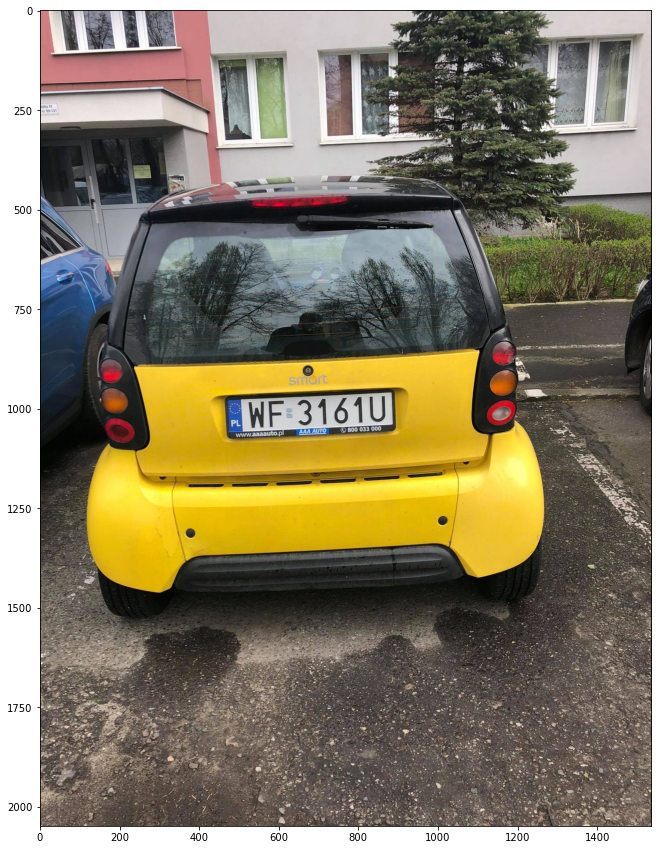

In [232]:
# Image
img = cv2.imread("in/7.jpg")
show(img)

### HSV Only black and white

In [233]:
hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

hsv_black_max = np.array([180, 255, 30],np.uint8)
hsv_black_min = np.array([0, 0, 0],np.uint8)
hsv_white_max = np.array([180, 18, 255],np.uint8)
hsv_white_min = np.array([0, 0, 0],np.uint8)
mask_white = cv2.inRange(hsv_img,hsv_white_min,hsv_white_max)
mask_black = cv2.inRange(hsv_img,hsv_black_min,hsv_black_max)

#showGray(mask_white)
#showGray(mask_black)

In [234]:
# Szary
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#showGray(img_gray)

### Filtrowanie

In [235]:
img_blur = cv2.blur(img_gray,(3,3))
img_blur_gauss = cv2.GaussianBlur(img_gray, (3, 3),0)
img_blur_median = cv2.medianBlur(img_gray,3)
img_blur_biltarealFilter = cv2.bilateralFilter(img_gray,11,21,7,cv2.BORDER_DEFAULT)

#showGray(img_blur)
#showGray(img_blur_gauss)
#showGray(img_blur_median)
#showGray(img_blur_biltarealFilter)

### Progowanie

In [236]:
_,img_threshold_otsu = cv2.threshold(img_blur_gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_,img_threshold_inv = cv2.threshold (img_blur_gauss, 120,255, cv2.THRESH_BINARY_INV)
img_threshold_mean = cv2.adaptiveThreshold(img_blur_gauss,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,25,10)
img_threshold_gauss = cv2.adaptiveThreshold(img_blur_gauss,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,10)

#showGray(img_threshold_otsu)
#showGray(img_threshold_inv)
#showGray(img_threshold_mean)
#showGray(img_threshold_gauss)

### Morph

In [237]:
kernel5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

img_morph = mask_black
#img_morph = cv2.morphologyEx(img_morph,cv2.MORPH_GRADIENT,kernel)
img_morph = cv2.dilate(img_morph,kernel5,iterations = 1)
img_morph = cv2.erode(img_morph, kernel3, iterations = 2)

#showGray(img_morph)

### Operator Canny'ego

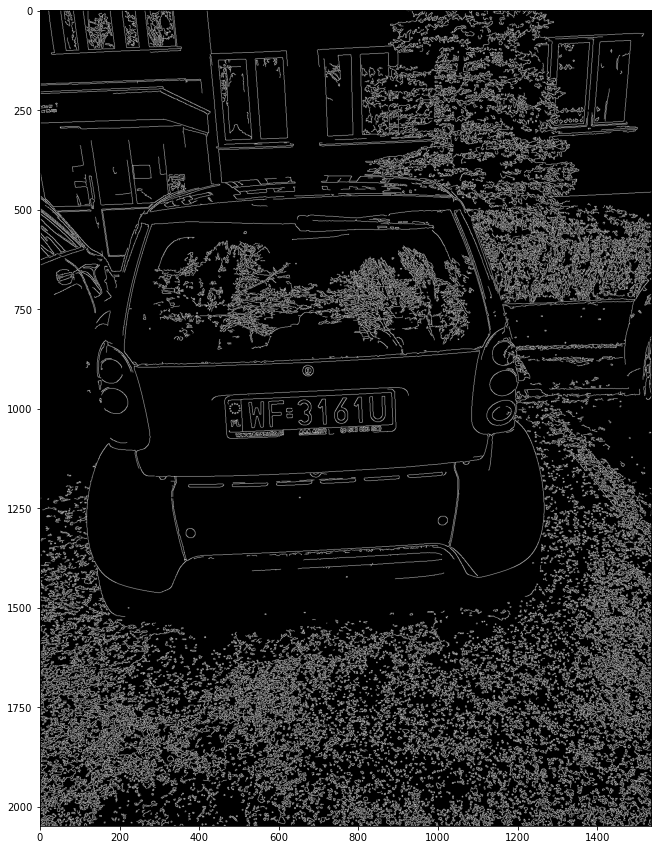

In [238]:
img_canny = cv2.Canny(img_blur_gauss, 87, 200)
showGray(img_canny)

# Wykrywanie tablic

### Krawędzie

In [249]:
all_contours, hierarchy = cv2.findContours(img_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#Wszystkie wewnętrzne kontury w konturze o danym indexie
def get_all_kid_contours(contours, hierarchy, index):
    result = []
    indexes = []
    
    pom = hierarchy[0][index][2]
    if(pom == -1):
        return result

    #next
    while pom != -1:
        indexes.append(pom)
        result.append(contours[pom])
        pom = hierarchy[0][pom][0]

    #previous
    pom = hierarchy[0][hierarchy[0][index][2]][1]
    while pom != -1:
        indexes.append(pom)
        result.append(contours[pom])
        pom = hierarchy[0][pom][1]

#     #Kids
#     for i in indexes:
#         result.extend(get_all_kid_contours(contours,hierarchy,i))

    return result

### Stałe

In [250]:
lp_width = 520
lp_height = 114
lp_char_height = 80

lp_width_max = lp_width * 3/2
lp_width_min = lp_width * 1/2
lp_height_max = lp_height * 3 / 2
lp_height_min = lp_height * 1 / 2
lp_m = (2 * lp_width + 2 * lp_height) / (2 * np.sqrt(np.pi * (lp_width * lp_height))) - 1
lp_m_max = (2 * lp_width_max + 2 * lp_height_min) / (2 * np.sqrt(np.pi * (lp_width_max * lp_height_min))) - 1
lp_m_min = (2 * lp_width_min + 2 * lp_height_max) / (2 * np.sqrt(np.pi * (lp_width_min * lp_height_max))) - 1

lp_wh = lp_width / lp_height
lp_wh_min = lp_width_min / lp_height_max
lp_wh_max = lp_width_max / lp_height_min

lp_char_ratio_max = (lp_char_height/lp_height) * 1.5
lp_char_ratio_min = (lp_char_height/lp_height) * 0.8

### Wykrywanie tablic

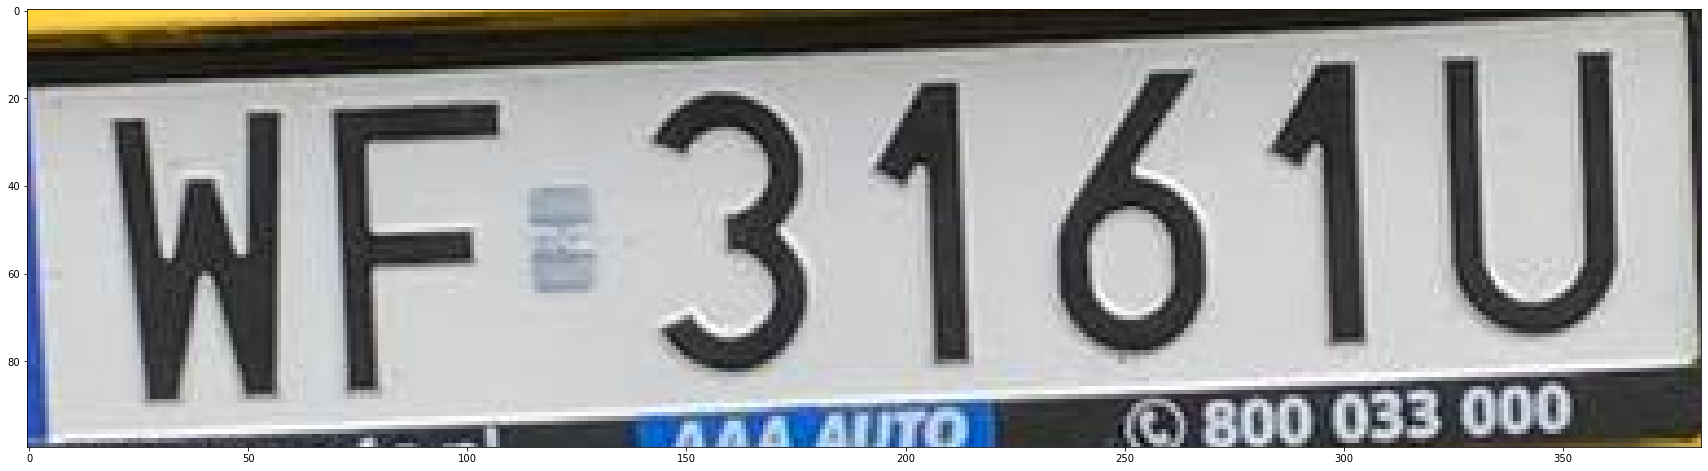

mEDJ93D


In [251]:
for index in range(len(all_contours)):
    con = all_contours[index]
    x,y,w,h = cv2.boundingRect(con)
    rect = cv2.minAreaRect(con)
    w_rect = rect[1][0]
    h_rect = rect[1][1]
    S = cv2.contourArea(con)
    L = cv2.arcLength(con, True)
    S_pred = w_rect * h_rect
    L_pred = 2*w_rect+2*h_rect
    
    #Pole większe od zadanej wartości oraz nie zerowy obwod
    if (S <= 100 or L == 0):
        continue

    #Pole konturru podobne do pola prostokąta
    if(not(S>S_pred*0.7 and S<S_pred*1.3)):
        continue

    #Obwód konturu podobny do obwodu prostokąta
    if(not(L>L_pred*0.7 and L<L_pred*1.3)):
        continue

    #Stosunek wysokości do długości
    if(not((max(w_rect,h_rect)/min(h_rect,w_rect) < lp_wh_max) and (max(w_rect,h_rect)/min(h_rect,w_rect) > lp_wh_min))):
        continue

    #Malinowskiej
    M = (L / (2 * np.sqrt(np.pi * S))) - 1
    if (not(M < max(lp_m_max,lp_m,lp_wh_min) and M > min(lp_m_max,lp_m,lp_wh_min))):
        continue

    kid_contours = get_all_kid_contours(all_contours, hierarchy, index)

    potential_char = []
    for kc in kid_contours:
        kc_rect = cv2.minAreaRect(kc)
        h_kc_rect = kc_rect[1][1]
        w_kc_rect = kc_rect[1][0]
        h_ratio = max(h_kc_rect,w_kc_rect)/min(h_rect,w_rect)
        if(h_ratio<lp_char_ratio_max and h_ratio>lp_char_ratio_min):
            potential_char.append(kc)

    if(not(len(potential_char)>3)):
        continue

    plate_label = ''
    for pc in potential_char:
        x_c,y_c,w_c,h_c = cv2.boundingRect(pc)
        char_image = img_blur[y_c-5:y_c + h +5, x_c-5 :x_c + w_c +5]
        _, char_threshold = cv2.threshold(char_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        char_threshold_rgb = cv2.cvtColor(char_threshold,cv2.COLOR_GRAY2RGB)
        char, pred = cr.recognize(char_threshold_rgb)
        plate_label = plate_label + char
        
    
    show(img[y:y+h,x:x+w])
    print(plate_label)